In [1]:
# ! pip install pandas numpy matplotlib rasterio dotenv

# ! pip freeze > ../requirements.txt

In [2]:
import os
import re
import rasterio
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from dotenv import load_dotenv

# Load Evnvironment

In [3]:
load_dotenv(".env")

ROOT_DATA_DIR = os.getenv("ROOT_DATA_DIR")
LANDCOVER_DIR = os.getenv("LANDCOVER_DIR")

SCALE_FACTOR = int(os.getenv("SCALE_FACTOR"))

# Constants

In [4]:
# get path to landcover files
base_landcover_path = f"{ROOT_DATA_DIR}{os.sep}{LANDCOVER_DIR}"
LANDCOVER_FILES = os.listdir(base_landcover_path)
LANDCOVER_FILES = [f"{base_landcover_path}{os.sep}{file}" for file in LANDCOVER_FILES]

In [6]:
LANDCOVER_COLORS = {
    0:"#FFFFFF00",
    1:"#1B5E20", 
    2:"#689F38", 
    3:"#9CCC65", 
    4:"#C5E1A5", 
    5:"#66BB6A", 
    6:"#004D40", 
    7:"#A5D6A7", 
    8: "#808000",
    9:"#005000", 
    10:"#2E7D32", 
    11:"#00897B", 
    12:"#004D40", 
    13:"#B2DFDB", 
    14:"#4DB6AC", 
    15:"#795548", 
    16:"#808080", 
    17:"#000000", 
    18:"#000080", 
    19:"#D0D0F0"
}

# Helper Functions

In [7]:
def get_year(file:str):
    year_re = r'landcover-(\d{4})-classification'
    year = re.search(year_re, file).group(1)
    del year_re
    return year

In [8]:
def get_landcover_data(
    file:str,
    scale_factor:int = SCALE_FACTOR
):
    with rasterio.open(file) as landcover_tif:
        print(f"Reading {file}...")

        # keep track of crs
        crs = landcover_tif.crs
        print(f"CRS: {landcover_tif.crs}")
        del crs

        # read file 
        landcover_data = landcover_tif.read(1) # reading channel 1 as there is only one band
        del landcover_tif

        # down scale for plotting
        print(f"Original Size: {landcover_data.shape}")
        if scale_factor < 1:
            raise ValueError("scale_factor can not be less than 1!!!")
        elif scale_factor > 1:
            landcover_data = landcover_data[::scale_factor, ::scale_factor]
        else:
            print("Skipping scaling")
        print(f"Downscale size: {landcover_data.shape}")

    return landcover_data

In [ ]:
def plot_landcover(
    landcover_data,
    fig_loc:str = None,
    title:str = None,
    figsize:tuple = (30, 30),
    cmap:str = None,
    color_dict:dict = LANDCOVER_COLORS,
    is_axis:bool = False
):
    plt.figure(
        figsize = figsize
    )

    # generate the color map 
    cmap = mcolors.ListedColormap(color_dict.values())

    # plot image
    plt.imshow(
        X = landcover_data,
        cmap = cmap
    )
    del cmap

    # axis off
    if not is_axis:
        plt.axis('off')
    
    # save the figure
    if fig_loc is not None:
        plt.savefig(
            fig_loc, 
            transparent = True,
            bbox_inches = 'tight', # compress the content  
            pad_inches = 0, # have no extra margin
        )
    # add title
    plt.title(title)

    # show image
    plt.show()


In [10]:
def save_landcover_counts(
    landcover_data, # sould be 1D
    file_name:str,
):
    print("Calculating the occurance of each type...")
    # get coutns
    landcover_counts = np.bincount(landcover_data) # note: this is fast but will only work with non -ve numbers 

    # build df
    landcover_count_df = pd.DataFrame(
        data = {
            'ID': range(len(landcover_counts)),
            'COUNT': landcover_counts
        }
    )
    
    # save data
    landcover_count_df.to_csv(
        file_name,
        index = False
    )
    print(f"Saved the occurance of each type > {file_name}")
    
    del landcover_counts
    del landcover_count_df
    del landcover_data

# Identity Change in LandCover

Reading ../../data/land_cover/landcover-2010-classification.tif...
CRS: EPSG:3979


Original Size: (160001, 190001)
Skipping scaling
Downscale size: (160001, 190001)
Reading ../../data/land_cover/landcover-2015-classification.tif...
CRS: EPSG:3979
Original Size: (160001, 190001)
Skipping scaling
Downscale size: (160001, 190001)
Calculating the occurance of each type...
Saved the occurance of each type > ../data/cache/landcover_canada_change_old_count_2010.csv
Calculating the occurance of each type...
Saved the occurance of each type > ../data/cache/landcover_canada_change_new_count_2015.csv


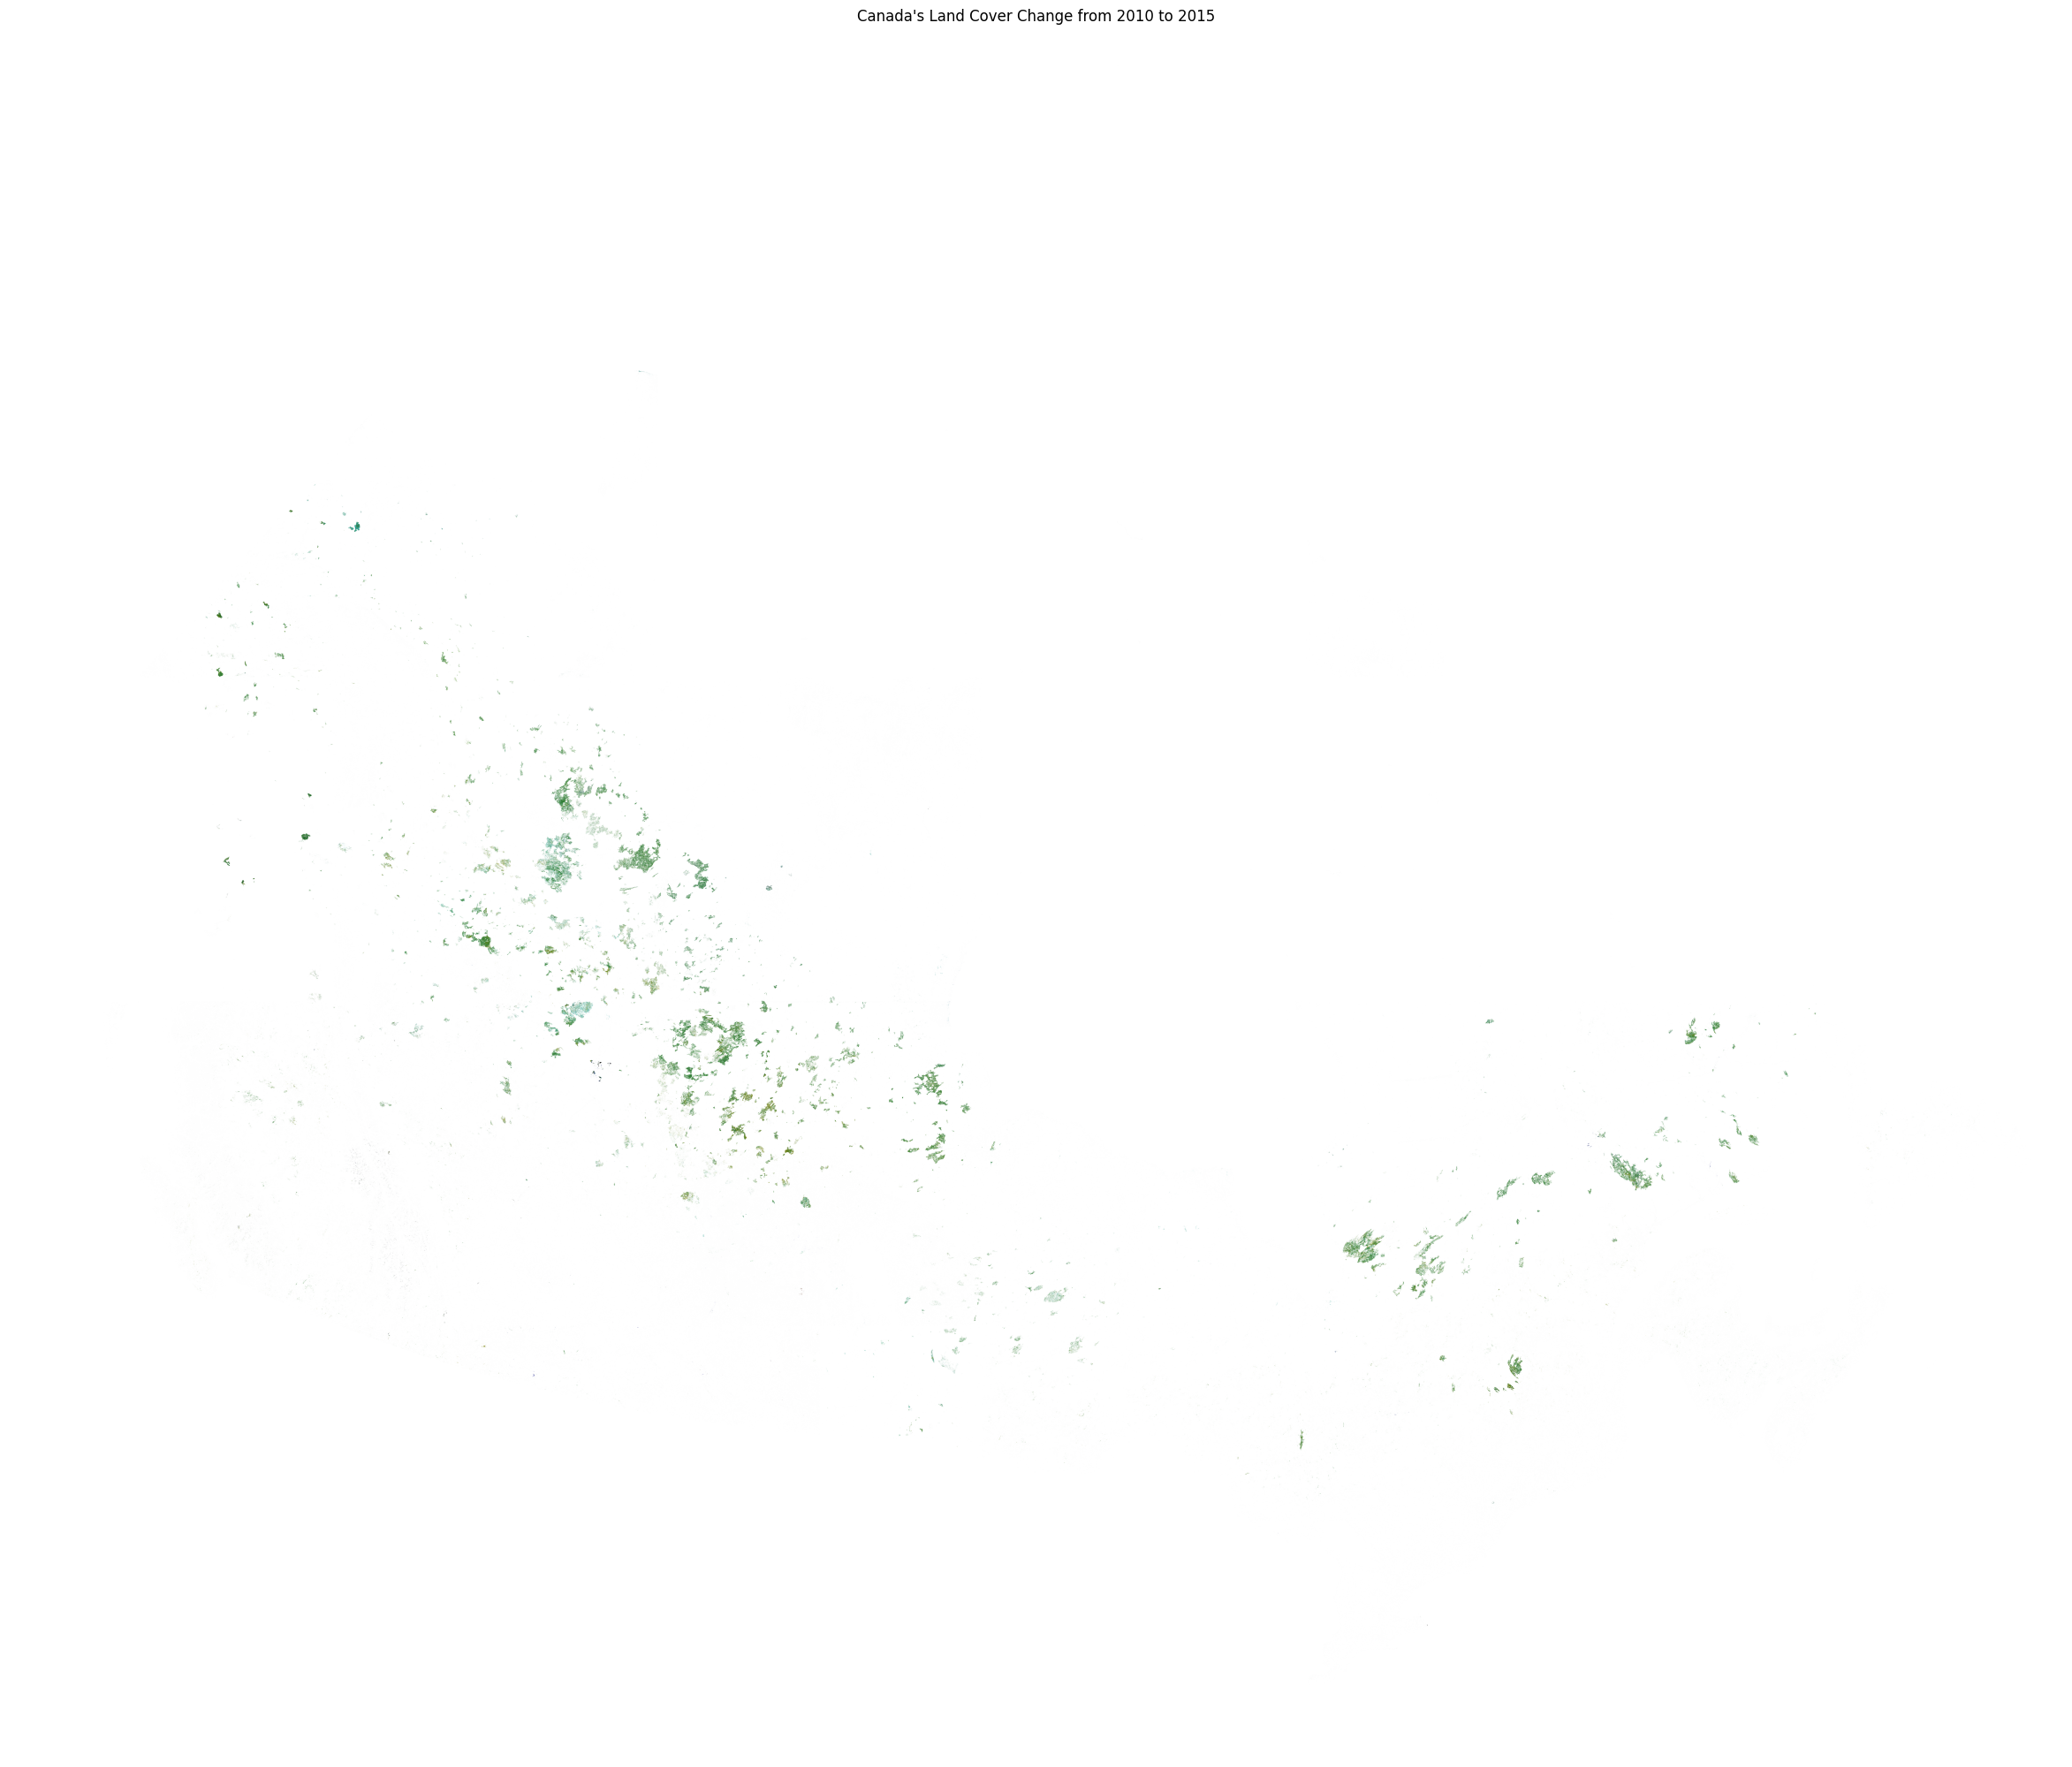

Reading ../../data/land_cover/landcover-2020-classification.tif...
CRS: EPSG:3979
Original Size: (160001, 190001)
Skipping scaling
Downscale size: (160001, 190001)
Calculating the occurance of each type...
Saved the occurance of each type > ../data/cache/landcover_canada_change_old_count_2015.csv
Calculating the occurance of each type...
Saved the occurance of each type > ../data/cache/landcover_canada_change_new_count_2020.csv


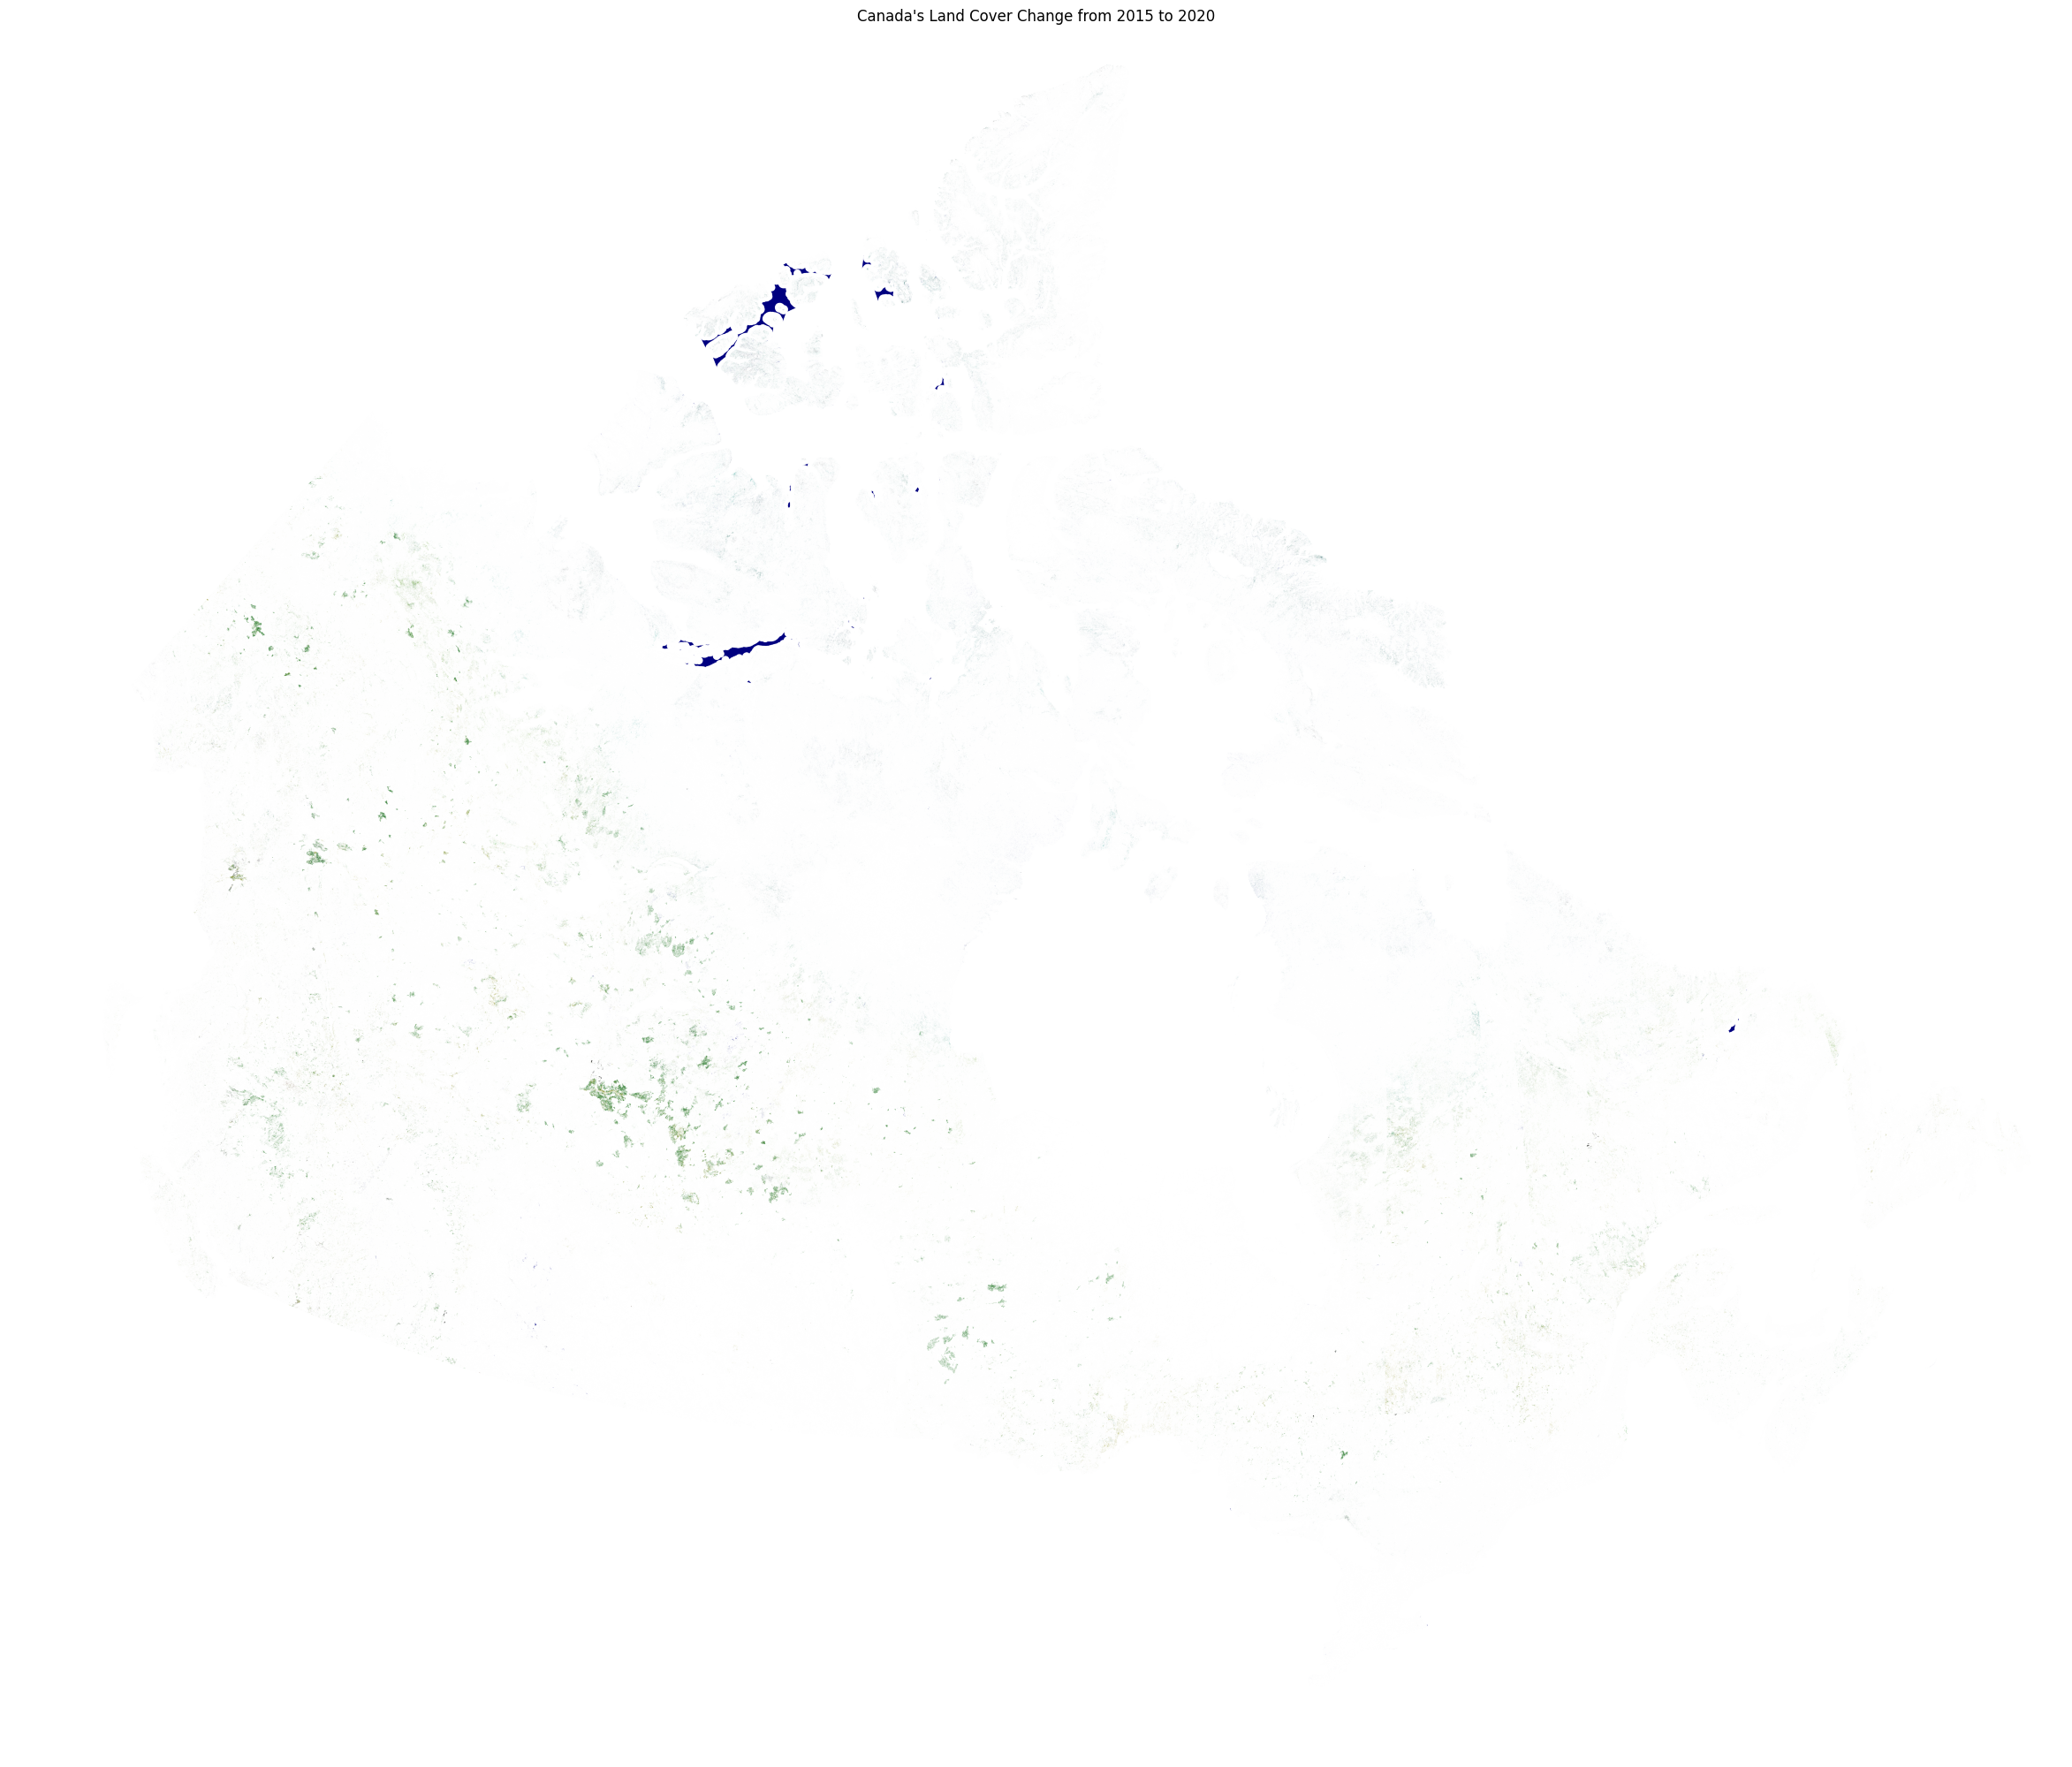

In [ ]:
# get landcover file
old_landcover_file = LANDCOVER_FILES[0]
# get year
old_landcover_year = get_year(old_landcover_file)
# get data
old_landcover_data = get_landcover_data(
    file = old_landcover_file,
    scale_factor = 1, # 1 since we want all the data 
)
# save the counts for each type
save_landcover_counts(
    landcover_data = old_landcover_data[old_landcover_data != 0],
    file_name = f"../data/cache/landcover_canada_count_{old_landcover_year}.csv"
)

for landcover_file_index in range(len(LANDCOVER_FILES) - 1): # since will be reading 2 file at a time
    # get new landcover file
    new_landcover_file = LANDCOVER_FILES[landcover_file_index + 1]
    # get new year
    new_landcover_year = get_year(new_landcover_file)
    # new get data
    new_landcover_data = get_landcover_data(
        file = new_landcover_file,
        scale_factor = 1, # 1 since we want all the data 
    )

    # identify change
    delta_land_cover_data = old_landcover_data != new_landcover_data

    # save change count
    save_landcover_counts(
        landcover_data = old_landcover_data[delta_land_cover_data],
        file_name = f"../data/cache/landcover_canada_change_old_count_{old_landcover_year}.csv"
    )
    save_landcover_counts(
        landcover_data = new_landcover_data[delta_land_cover_data],
        file_name = f"../data/cache/landcover_canada_change_new_count_{new_landcover_year}.csv"
    )

    del old_landcover_file
    del old_landcover_year
    del old_landcover_data

    # updated new to old
    old_landcover_file = new_landcover_file
    old_landcover_year = new_landcover_year
    old_landcover_data = deepcopy(new_landcover_data)

    # mask unchanged data
    new_landcover_data[~delta_land_cover_data] = 0
    del delta_land_cover_data

    # plot only the change
    plot_landcover(
        new_landcover_data[::SCALE_FACTOR, ::SCALE_FACTOR],
        title = f"Canada's Land Cover Change from {int(old_landcover_year)-5} to {old_landcover_year}",
        fig_loc = f"../assets/figures/landcover_canada_changed_{int(old_landcover_year)-5}_to_{old_landcover_year}.png"
    )
    
    del new_landcover_file
    del new_landcover_year
    del new_landcover_data

    # save the new counts for each type
    save_landcover_counts(
        landcover_data = old_landcover_data[old_landcover_data != 0],
        file_name = f"../data/cache/landcover_canada_count_{old_landcover_year}.csv"
    ) # running at the end to get more memory adter deleting unused stuff

del old_landcover_file
del old_landcover_year
del old_landcover_data